In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

import os
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

from hyperparameters import *
from Generator import Generator
from Discriminator import Discriminator

np.random.seed(0)
torch.cuda.manual_seed(0)

In [2]:
data = datasets.MNIST(
    root='./data'
    , download=True
    , transform=transforms.Compose([
        transforms.Resize(SZ)
        , transforms.ToTensor()
        , transforms.Normalize((.5,), (.5,))
    ])
)

dl = DataLoader(data, batch_size=BATCH_SZ, shuffle=True, num_workers=4, pin_memory=True)

Label: 2


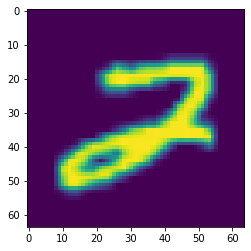

In [3]:
for data, target in dl:
    data, target = data[0].squeeze(0).numpy(), target[0]
    display(plt.imshow(data))
    print(f'Label: {target}')
    break

In [4]:
def init_weights(cls):
    cls_name = cls.__class__.__name__

    # init weights for conv tensors
    if cls_name.find('Conv') != -1:
        cls.weight.data.normal_(0.0, 0.02)

    # init weights for batch normalization tensors
    elif cls_name.find('BatchNorm') != -1:
        cls.weight.data.normal_(1.0, 0.02)
        cls.bias.data.fill_(0)


In [5]:
# create Generator instance and move to cuda
gen = Generator().cuda()
# create Discriminator instance and move to cuda
dis = Discriminator().cuda()

# apply init_weights() to all layers
gen.apply(init_weights)
dis.apply(init_weights)

# print summaries
print('-'*5 + 'Generator' + '-'*5)
display(summary(gen, input_size=(100, 1, 1)))
print('\n' + '-'*5 + 'Discriminator' + '-'*5)
display(summary(dis, input_size=(1, 100, 100)))

-----Generator-----
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
         LeakyReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
         LeakyReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        LeakyReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           1,024
             Tanh-1

None

None

In [6]:
criterion = nn.BCELoss()
d_opt = optim.Adam(dis.parameters(), lr=LR, betas=(0.88, 0.99))
g_opt = optim.Adam(gen.parameters(), lr=LR, betas=(0.88, 0.99))

In [7]:
sample_noise = torch.randn(BATCH_SZ, GEN_IN, 1, 1).cuda()
print(sample_noise.shape)

torch.Size([512, 100, 1, 1])


In [8]:
history = {
'd_loss_real': [],
'd_loss_fake': [],
'd_acc': [],
'g_loss': [],
}

D_BEST_LOSS = float('inf')
G_BEST_LOSS = float('inf')

for epoch in range(EPOCHS):
    for idx, (data, target) in enumerate(dl):
        # move data and target to cuda
        data, target = data.cuda(), target.cuda()
        # create tensors for real and fake targets (1 / 0)
        data_real = data
        target_real = torch.full((data_real.size(0), ), REAL_TARGET).cuda()
        target_fake = torch.full((data_real.size(0), ), FAKE_TARGET).cuda()

        # Train discriminator on **REAL** data
        dis.zero_grad()
        pred_real = dis(data_real)
        d_loss_real = criterion(pred_real, target_real)
        d_loss_real.backward()

        # Train discriminator on **FAKE** data
        gen_noise = torch.randn(data_real.size(0), GEN_IN, 1, 1).cuda()
        data_fake = gen(gen_noise)
        pred_fake = dis(data_fake.detach())
        d_loss_fake = criterion(pred_fake, target_fake)
        d_loss_fake.backward()
        d_opt.step()

        # Train generator on fake data
        gen.zero_grad()
        gen_fake = dis(data_fake)
        g_loss = criterion(gen_fake, target_real)
        g_loss.backward()
        g_opt.step()

        # calculate mean losses
        d_loss_fake = d_loss_fake.mean().item()
        d_loss_real = d_loss_real.mean().item()
        g_loss = g_loss.mean().item()

        # Add loss to history
        history['d_loss_real'].append(d_loss_real)
        history['d_loss_fake'].append(d_loss_fake)
        history['g_loss'].append(g_loss)

        if idx % (BATCH_SZ / 2) == 0:

            # save progress images
            save_image(data_real, './progress_images/real_sample.png', normalize=True)
            with torch.no_grad():
                sample_img = gen(sample_noise)
                save_image(sample_img, f'./progress_images/gen_sample{epoch}.png', normalize=True)

            # print status updates
            print(f'\n-----Epoch: {epoch + 1}/{EPOCHS} Batch: {idx}/{BATCH_SZ}-----'
                  f'\nDiscriminator loss on real data: {d_loss_real:.4f}'
                  f'\nDiscriminator loss on fake data: {d_loss_fake:.4f}'
                  f'\nGenerator loss: {g_loss:.4f}')

        torch.save(dis.state_dict(), f'./models/discriminator{epoch}.pt')
        torch.save(gen.state_dict(), f'./models/generator{epoch}.pt')

..\aten\src\ATen\native\TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.



-----Epoch: 1/50 Batch: 0/512-----
Discriminator loss on real data: 0.8546
Discriminator loss on fake data: 0.4380
Generator loss: 2.4076

-----Epoch: 2/50 Batch: 0/512-----
Discriminator loss on real data: 0.0060
Discriminator loss on fake data: 0.0028
Generator loss: 9.4927

-----Epoch: 3/50 Batch: 0/512-----
Discriminator loss on real data: 0.0312
Discriminator loss on fake data: 0.0124
Generator loss: 8.7036

-----Epoch: 4/50 Batch: 0/512-----
Discriminator loss on real data: 0.0070
Discriminator loss on fake data: 0.0573
Generator loss: 9.2874

-----Epoch: 5/50 Batch: 0/512-----
Discriminator loss on real data: 0.0057
Discriminator loss on fake data: 0.0000
Generator loss: 13.4710

-----Epoch: 6/50 Batch: 0/512-----
Discriminator loss on real data: 0.0046
Discriminator loss on fake data: 0.0559
Generator loss: 6.4188

-----Epoch: 7/50 Batch: 0/512-----
Discriminator loss on real data: 0.0000
Discriminator loss on fake data: 0.0001
Generator loss: 10.3386

-----Epoch: 8/50 Batch: 

Magic: 


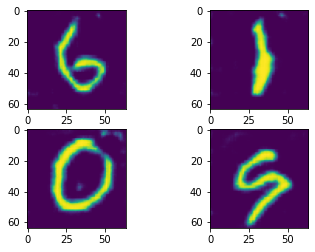

In [19]:
noise = torch.randn(4, GEN_IN, 1, 1).cuda()
out = gen(noise).cpu().detach().numpy()

print('Magic: ')

for idx, T in enumerate(out):
    plt.subplot(2, 2, idx+1)
    plt.imshow(T.squeeze(0))

